In [3]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets
from datasets import load_dataset

from utils import add_size, sample_eval_losses

### Setup
**Here we create small 10k datasets for the analysis (you can push them to hub for further experiments)**

* On safe license raw dataset

In [4]:
safe_ds = load_dataset('BigCode/github_dump_v2_python_only_safe_licenses', use_auth_token=True, streaming=True, split="train")
safe_ds = safe_ds.shuffle(seed=42)
# 10k subset of random samples from ds
safe_ds = list(safe_ds.take(10_000))
subset_safe_ds = datasets.Dataset.from_pandas(pd.DataFrame(data=safe_ds))
subset_safe_ds = subset_safe_ds.map(add_size)
#repo_name = "loubnabnl"
#subset_ds.push_to_hub("{repo_name}/bigcode_safe_license_10k_subset")

Using custom data configuration BigCode--github_dump_v2_python_only_safe_licenses-51fd93c2f3532ee9
100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 15096.59ex/s]


* On safe license filtered dataset

In [5]:
safe_filter_ds = load_dataset('BigCode/github-python-safe-license-conf-test-filter', use_auth_token=True, streaming=True, split="train")
safe_filter_ds = safe_filter_ds.shuffle(seed=42)
safe_filter_ds = list(safe_filter_ds.take(10_000))
subset_safe_filter_ds = datasets.Dataset.from_pandas(pd.DataFrame(data=safe_filter_ds))
subset_safe_filter_ds = subset_safe_filter_ds.map(add_size)

Using custom data configuration BigCode--github-python-safe-license-conf-test-filter-fb0017e63f831bcf
100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10041.19ex/s]


* On all license raw dataset

In [5]:
all_ds = load_dataset('BigCode/github_dump_python_only_any_license_decompressed', use_auth_token=True, streaming=True, split="train")
all_ds = all_ds.shuffle(seed=42)
all_ds = list(all_ds.take(10_000))
subset_all_ds = datasets.Dataset.from_pandas(pd.DataFrame(data=all_ds))
subset_all_ds = subset_all_ds.map(add_size)

Using custom data configuration BigCode--github_dump_python_only_any_license_decompressed-a12d560cdde6f7a4
100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 15812.10ex/s]


* On all license filtered dataset

In [8]:
all_filter_ds = load_dataset('BigCode/github-python-all-license-conf-test-filter', use_auth_token=True, streaming=True, split="train")
all_filter_ds = all_filter_ds.shuffle(seed=42)
all_filter_ds = list(all_filter_ds.take(10_000))
subset_all_filter_ds = datasets.Dataset.from_pandas(pd.DataFrame(data=all_filter_ds))
subset_all_filter_ds = subset_all_filter_ds.map(add_size)

Using custom data configuration BigCode--github-python-all-license-conf-test-filter-26d53009d76c2cc0
100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10485.68ex/s]


### Analysis

datasets: subset_safe_ds, subset_safe_filter_ds, subset_all_filter_ds, subset_all_ds
* analyze the distribution of short files in each dataset
* compute loss distribution over short vs small files for each model

#### 1 - file size distribution

Text(0.5, 1.0, 'distribution of file size on a 10k random subset')

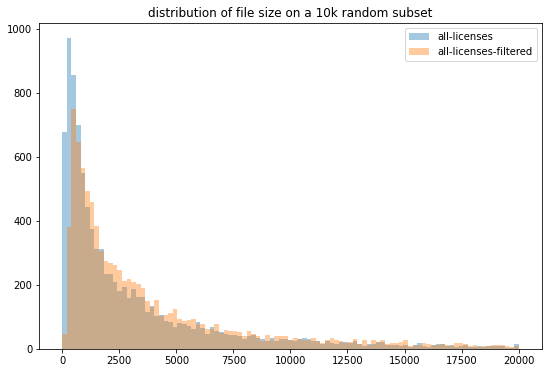

In [11]:
plt.figure(figsize=(9,6))
plt.hist(subset_all_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="all-licenses");
plt.hist(subset_all_filter_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="all-licenses-filtered");
plt.legend(prop ={'size': 10})
plt.title("distribution of file size on a 10k random subset")

As expected the filtering removed any of the short files

Text(0.5, 1.0, 'distribution of file size on a 10k random subset')

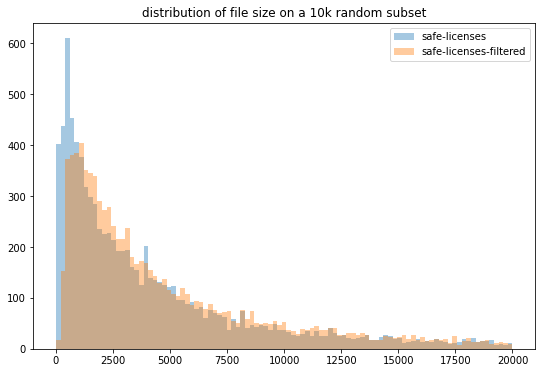

In [12]:
plt.figure(figsize=(9,6))
plt.hist(subset_safe_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="safe-licenses");
plt.hist(subset_safe_filter_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="safe-licenses-filtered");
plt.legend(prop ={'size': 10})
plt.title("distribution of file size on a 10k random subset")

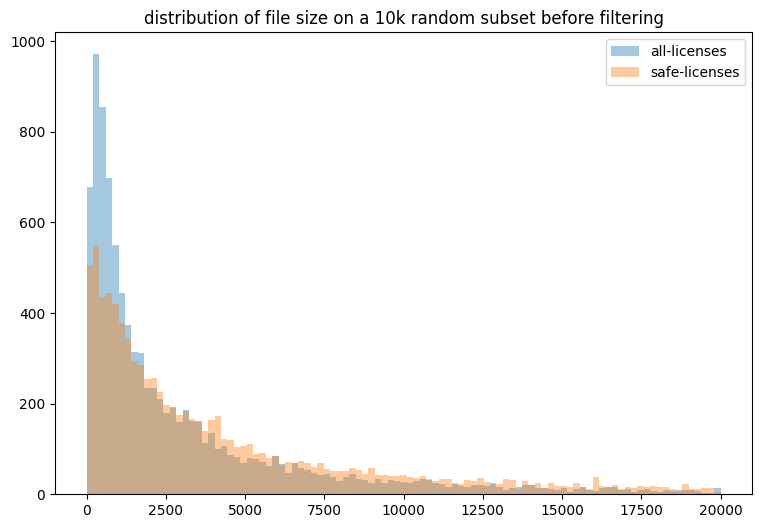

In [7]:
plt.figure(figsize=(9,6))
plt.hist(subset_all_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="all-licenses");
plt.hist(subset_safe_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="safe-licenses");
plt.legend(prop ={'size': 10})
plt.title("distribution of file size on a 10k random subset before filtering");

**=> the dataset with all licenses has more short files**

Text(0.5, 1.0, 'distribution of file size on a 10k random subset of safe-license-dataset')

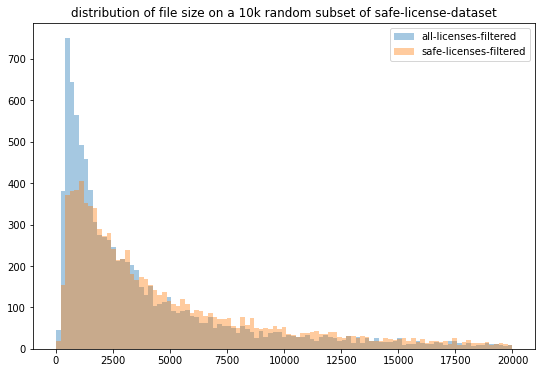

In [14]:
plt.figure(figsize=(9,6))
plt.hist(subset_all_filter_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="all-licenses-filtered");
plt.hist(subset_safe_filter_ds['size'], bins=np.linspace(0, 20000, 100), alpha=0.4, label="safe-licenses-filtered");
plt.legend(prop ={'size': 10})
plt.title("distribution of file size on a 10k random subset of safe-license-dataset")

### 2 - loss analysis

Plan:
* compute statistics for each model of the loss on both datasets
* compute statistics on the short files (less than 2000) of the datasets

In [15]:
#load models
tokenizer_all_license = AutoTokenizer.from_pretrained("BigCode/gpt_345_python_only_any_license", use_auth_token=True)
model_all_license = AutoModelForCausalLM.from_pretrained("BigCode/gpt_345_python_only_any_license", use_auth_token=True)

tokenizer_safe_license = AutoTokenizer.from_pretrained("BigCode/gpt_345_python_only_safe_licenses_v2", use_auth_token=True)
model_safe_license = AutoModelForCausalLM.from_pretrained("BigCode/gpt_345_python_only_safe_licenses_v2", use_auth_token=True)

In [16]:
ds_short = subset_all_ds.filter(lambda example: example["size"] < 750)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 58.69ba/s]


In [17]:
ds_long = subset_all_ds.filter(lambda example: example["size"] > 10000)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 108.18ba/s]


In [22]:
print(len(ds_short))
print(len(ds_long))
length = min(len(ds_short), len(ds_long))

3015
1208


In [23]:
losses_all_short, losses_safe_short = sample_eval_losses(model_all_license, model_safe_license, tokenizer_all_license, tokenizer_safe_license, ds_short, n=length,  device="cuda")

100%|███████████████████████████████████████| 1208/1208 [02:02<00:00,  9.87it/s]


In [24]:
losses_all_long, losses_safe_long = sample_eval_losses(model_all_license, model_safe_license, tokenizer_all_license, tokenizer_safe_license, ds_long, n=length,  device="cuda")

100%|███████████████████████████████████████| 1208/1208 [08:01<00:00,  2.51it/s]


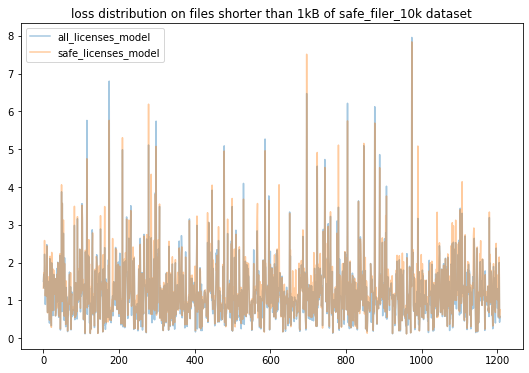

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(losses_all_short, alpha=0.4, label="all_licenses_model");
plt.plot(losses_safe_short, alpha=0.4, label="safe_licenses_model");
plt.legend(prop ={'size': 10})
plt.title("loss distribution on files smaller than 1kB of safe_filer_10k dataset");

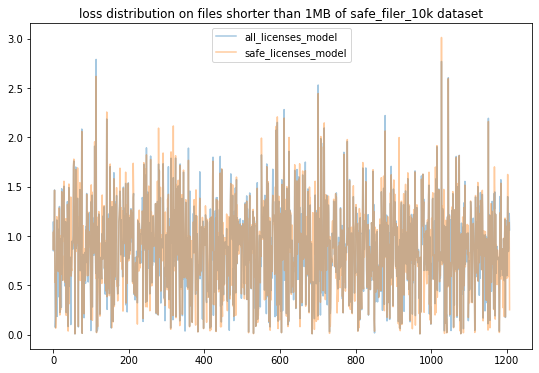

In [26]:
from matplotlib import pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(losses_all_long, alpha=0.4, label="all_licenses_model");
plt.plot(losses_safe_long, alpha=0.4, label="safe_licenses_model");
plt.legend(prop ={'size': 10})
plt.title("loss distribution on files larger than 10kB of safe_filer_10k dataset");

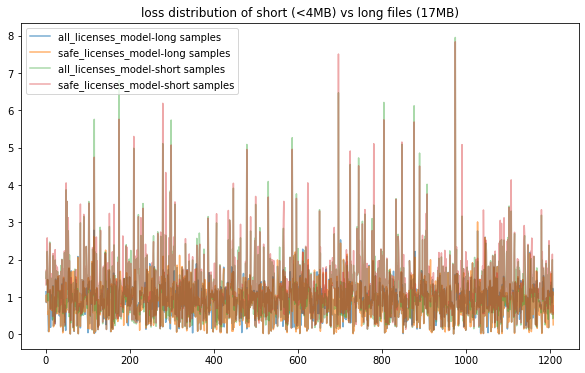

In [27]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(losses_all_long, alpha=0.6, label="all_licenses_model-long samples");
plt.plot(losses_safe_long, alpha=0.6, label="safe_licenses_model-long samples");

plt.plot(losses_all_short, alpha=0.4, label="all_licenses_model-short samples");
plt.plot(losses_safe_short, alpha=0.4, label="safe_licenses_model-short samples");

plt.legend(prop ={'size': 10})
plt.title("loss distribution of short (<4MB) vs long files (17MB)");

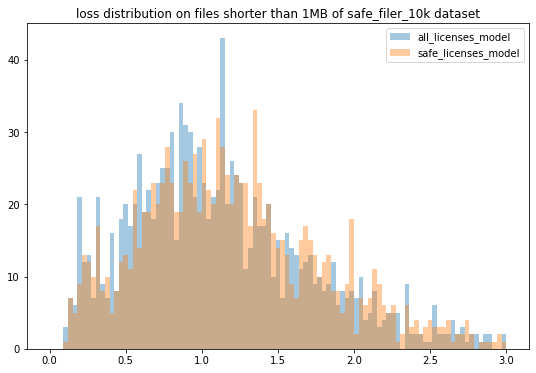

In [28]:
plt.figure(figsize=(9,6))
plt.hist(losses_all_short, bins=np.linspace(0, 3, 100), alpha=0.4, label="all_licenses_model");
plt.hist(losses_safe_short, bins=np.linspace(0, 3, 100), alpha=0.4, label="safe_licenses_model");
plt.legend(prop ={'size': 10})
plt.title("loss distribution on files shorter than 1MB of safe_filer_10k dataset");

### Visualization of short files

In [29]:
ds_very_short = subset_safe_filter_ds.filter(lambda example: example["size"] < 600)
iterator = iter(ds_very_short)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 89.99ba/s]


In [31]:
print(next(iterator)["content"])

import pandas as pd


def main():
    wb = pd.ExcelFile("excel_wb.xlsx")
    print(f"Workbook Sheets: {wb.sheet_names}")
    df = wb.parse(wb.sheet_names[0])
    df = df.set_index("UID")
    users_dict = df.to_dict("index")
    print(users_dict)


if __name__ == "__main__":
    main()



In [32]:
print(next(iterator)["content"])

import scrapy


class OnlinetournamentsItem(scrapy.Item):

    country = scrapy.Field()
    playerID = scrapy.Field()
    playerName = scrapy.Field()
    totalOnline = scrapy.Field()
    results = scrapy.Field()
    mostGame = scrapy.Field()
    mostGameResults = scrapy.Field()



In [133]:
print(next(iterator)["content"])

def dolzina_collatzovo(n):
    sez = []
    while n != 1: 
        sez.append(n)           
        if n % 2 == 0:
            n //= 2
        else:
            n = n * 3 + 1
    return len(sez)

def vsa_zaporedja_do_stevila(stevilo):
    n = 1
    dolzina_zacetni = {}
    while n != stevilo:
        dolzina_zacetni[dolzina_collatzovo(n)] = n
        n += 1
    return dolzina_zacetni[max(dolzina_zacetni)]

print(vsa_zaporedja_do_stevila(1000000))     


In [134]:
print(next(iterator)["content"])

#!/usr/bin/env python



from __future__ import print_function
import numpy as np
from layer import Layer

class ReLULayer(Layer):
    """
    docstring for ReLULayer
    """
    def __init__(self, arg):
        super(ReLULayer, self).__init__()
        self.arg = arg

    def fprop(self, X):
        out = np.maximum(X, 0)
        cache = X
        return out, cache

    def bprop(self, dout, cache):
        dX = dout.copy()
        dX[cache <= 0] = 0
        return dX



In [135]:
print(next(iterator)["content"])

#!/usr/bin/env python



from __future__ import print_function
import numpy as np
from layer import Layer

class FullyConnectedLayer(Layer):
    """
    docstring for FullyConnectedLayer
    """
    def __init__(self, arg):
        super(FullyConnectedLayer, self).__init__()
        self.arg = arg

    def fprop(self, X, W, b):
        out = X @ W + b
        cache = (W, X)
        return out, cache

    def bprop(self, dout, cache):
        W, h = cache

        dW = h.T @ dout
        db = np.sum(dout, axis=0)
        dX = dout @ W.T

        return dX, dW, db
        



In [136]:
print(next(iterator)["content"])

# -*- coding: utf-8 -*-
from __future__ import unicode_literals

from django.db import models, migrations
import versionfield


class Migration(migrations.Migration):

    dependencies = [
    ]

    operations = [
        migrations.CreateModel(
            name='Um',
            fields=[
                ('id', models.AutoField(serialize=False, verbose_name='ID', auto_created=True, primary_key=True)),
                ('texto', models.TextField()),
                ('versao', versionfield.VersionField()),
            ],
        ),
    ]



In [137]:
print(next(iterator)["content"])

import threading
import time


def spawn(*args, **kwargs):
    def _launch(func, *args, **kwargs):
        func(*args, **kwargs)
    t = threading.Thread(target=_launch, args=args, kwargs=kwargs)
    t.daemon = True
    t.start()
    return t


def kill(thread):
    thread.terminate()


def killall(threads):
    for t in threads:
        kill(t)


def join(thread):
    thread.join()


def joinall(threads):
    for t in threads:
        join(t)


sleep = time.sleep



In [138]:
print(next(iterator)["content"])

"""
For in em Python

Iterando string com for
Função range(start=0, stop, step=1)
"""
texto = 'Python'
nova_string = ''

for letra in texto:
    if letra == 't':
        nova_string = nova_string + letra.upper()
    elif letra == 'h':
        nova_string += letra.upper()
        break
    else:
        nova_string += letra

print(nova_string)
""""
for n, letra in enumerate(texto):
    print(n, letra)
"""



In [139]:
print(next(iterator)["content"])

from distutils.core import setup
import numpy as np

from Cython.Build import cythonize

setup(
    name='pyhsmm_spiketrains',
    version='0.1',
    description='Bayesian inference for Poisson latent state space models',
    author='Scott Linderman',
    author_email='slinderman@seas.harvard.edu',
    url='http://www.github.com/slinderman/pyhsmm-spiketrains',
    ext_modules=cythonize('**/*.pyx'),
    include_dirs=[np.get_include(),],
)



In [140]:
print(next(iterator)["content"])

# Generated by Django 2.0.4 on 2018-06-05 12:09

from django.db import migrations, models


class Migration(migrations.Migration):

    dependencies = [
        ('teams', '0002_team_score'),
    ]

    operations = [
        migrations.AddField(
            model_name='team',
            name='last_submit',
            field=models.DateTimeField(blank=True, default=None, null=True),
        ),
    ]



In [141]:
print(next(iterator)["content"])

#Fills in values with the most common occurrence of an item, used with grouping
def fill_values(series):
    values_counted = series.value_counts()
    if values_counted.empty:
        return series
    most_frequent = values_counted.index[0]
    new_medium = series.fillna(most_frequent)
    return new_medium

# Transform
grouped_mediums = small_df.groupby('artist')['medium']
small_df.loc[:, 'medium'] = grouped_mediums.transform(fill_values)


In [142]:
print(next(iterator)["content"])

import cv2
import argparse

parser = argparse.ArgumentParser(description='Convert frames to a video')
parser.add_argument('--frames', default='./images', type=str, help='video frames file')
parser.add_argument('--input', default='./video', type=str, help='input video name')
args = parser.parse_args()


vidcap = cv2.VideoCapture(args.input)
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite(args.frames + "/%s.jpg" % str(count).zfill(6), image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1


In [143]:
print(next(iterator)["content"])

from django.db import models
from django.contrib.auth.models import AbstractUser
from .validators import validate_no_special_characters

class User(AbstractUser):
    nickname = models.CharField(
        max_length=15,
        unique=True,
        null=True,
        validators=[validate_no_special_characters],
        error_messages={"unique": "이미 사용중인 닉네임입니다."},
    )

    def __str__(self):
        return self.email



In [144]:
print(next(iterator)["content"])

#!/usr/bin/env python3
# 2018 Daniel Varga (vargad88@gmail.com)

from itertools import permutations

def joindigits(arr):
    return int(''.join((str(d) for d in arr)))

def solve():
    for p in permutations(range(1,10), 9):
        if (p[7]*p[8])%10 != p[3]: continue
        d,m = divmod(joindigits(p[0:4]), joindigits(p[4:8]))
        if m == 0 and d == p[8]: yield p

for s in solve():
    print(f"{joindigits(s[0:4])}/{joindigits(s[4:8])}={s[8]}")



In [145]:
print(next(iterator)["content"])

import random

print("Hello, what is your favourite number?")
number=input()

print("Your fav number is "+number)

minNumber=1
maxNumber=100
magicNumber = random.randint(minNumber,maxNumber)


message="This magic number is between {0} and {1}"
print(message.format(minNumber,maxNumber))


found= False

while not found:
    print("Guess what it is?")
    guess = int(input())
    if guess ==magicNumber:
        found=True
    if guess<magicNumber:
        print("Too low")
    if guess>magicNumber:
        print("Too high")
        

print("You got it")



In [146]:
print(next(iterator)["content"])

from flask import render_template
from . import main
from ..requests import get_news
from ..models import Source, Article


Review = reviews.Review

# views

@main.route('/')
def index() :
    sources = get_news()
    print(sources)
    
    title = 'Home - welcome '
    return render_template('index.html', title=title, sources=sources)









## Loss on Human Eval prompts/solutions

In [44]:
humaneval = load_dataset("openai_humaneval", split="test")

Reusing dataset openai_humaneval (/home/loubna_huggingface_co/.cache/huggingface/datasets/openai_humaneval/openai_humaneval/1.0.0/2955cebd73602e828fa8c0a424c594e5fab4ec863b316ca98f3d8fdb6a626e75)


In [49]:
from tqdm import tqdm

def sample_eval_losses(model_all_license, model_safe_license, tokenizer_all, tokenizer_safe, ds, mode = "prompt", n=1500,  device="cuda"):
    """ compute losses on the first n samples for both models"""
    losses_all = []
    losses_safe = []
    model_all_license.to(device)
    model_safe_license.to(device)
    for i in tqdm(range(n)):
        with torch.no_grad():
            tokens_all = torch.tensor(tokenizer_all(ds[i][mode], truncation=True)['input_ids'])
            tokens_safe = torch.tensor(tokenizer_safe(ds[i][mode], truncation=True)['input_ids'])
            
            outputs = model_all_license(tokens_all.to(device), labels=tokens_all.to(device))
            losses_all.append(outputs.loss.item())
            outputs = model_safe_license(tokens_safe.to(device), labels=tokens_safe.to(device))
            losses_safe.append(outputs.loss.item())
            
    return losses_all, losses_safe

In [50]:
loss_1, loss_2 = sample_eval_losses(model_all_license, model_safe_license, tokenizer_all_license, tokenizer_safe_license, humaneval, mode="prompt", n=len(humaneval),  device="cuda")

100%|█████████████████████████████████████████| 164/164 [00:08<00:00, 19.60it/s]


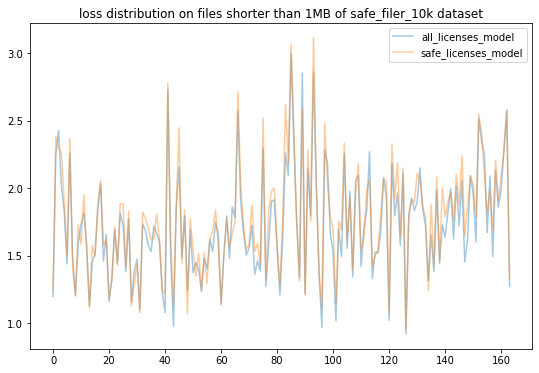

In [51]:
from matplotlib import pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(loss_1, alpha=0.4, label="all_licenses_model");
plt.plot(loss_2, alpha=0.4, label="safe_licenses_model");
plt.legend(prop ={'size': 10})
plt.title("loss distribution on files shorter than 1MB of safe_filer_10k dataset");

In [ ]:
loss_1, loss_2 = sample_eval_losses(model_all_license, model_safe_license, tokenizer_all_license, tokenizer_safe_license, humaneval, mode="canonical_solution", n=len(humaneval),  device="cuda")

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(9,6))
plt.plot(loss_1, alpha=0.4, label="all_licenses_model");
plt.plot(loss_2, alpha=0.4, label="safe_licenses_model");
plt.legend(prop ={'size': 10})
plt.title("loss distribution on files shorter than 1MB of safe_filer_10k dataset");